# TileDB Quickstart Notebook

This notebook will walk through usage of TileDB Cloud including User Defined Functions and Serverless SQL

We will start off using the quickstart example arrays and then move to a real work dataset based on transit data from the Boston metro area.

In [2]:
import tiledb, tiledb.cloud
import pandas
import numpy

In [3]:
# In TileDB Cloud hosted notebooks you are automatically signed in to the tiledb cloud python client
# Uncomment the login command if running outside of TileDB Cloud
#tiledb.cloud.login(username="xxx", password="yyy")

First let's access the quickstart sparse array through the cloud service.

In [4]:
with tiledb.open("tiledb://TileDB-Inc/quickstart_sparse", ctx=tiledb.cloud.Ctx()) as A:
    df = pandas.DataFrame(A[:])

df

,a,rows,cols
0,1,1,1
1,3,2,3
2,2,2,4


Next let's run User Defined Function. This will compute the mean of the "a" attribute.

In [5]:
def mean(data):
    import numpy
    return numpy.mean(data["a"])

# Run UDF on entire dataset
with tiledb.open("tiledb://TileDB-Inc/quickstart_sparse", ctx=tiledb.cloud.Ctx()) as A:
    results = A.apply(mean, [(1,4), (1,4)])

results

TileDBCloudError: Docker logs: Traceback (most recent call last):
  File "/opt/array_udf_entry.py", line 918, in <module>
    main()
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1137, in __call__
    return self.main(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1062, in main
    rv = self.invoke(ctx)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 1404, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/opt/conda/lib/python3.7/site-packages/click/core.py", line 763, in invoke
    return __callback(*args, **kwargs)
  File "/opt/array_udf_entry.py", line 720, in main
    udf_function = cloudpickle.loads(pickled_udf)
TypeError: code() takes at most 15 arguments (16 given)

Error(s): received an error from the container: docker container exited with non-zero code: 1. - Code: 5000

A serverless SQL query can also be run to to compute the mean. Serverless SQL returns a pandas dataframe of the results.

In [ ]:
# Run sql
results = tiledb.cloud.sql.exec("select AVG(`a`) as avg from `tiledb://TileDB-Inc/quickstart_sparse` WHERE `rows` between 1 and 4 and `cols` between 1 and 4")
results

,avg
0,2


# Realworld Example

Using ridership data from the MBTA[1] (Boston-area Transit Authority) we will run a sql query to extract ridership data for all services exclusing buses and then create a line graph.

The dataset has already been loaded into a tiledb array for this example.


[1] Data taken from MBTA data dashboard https://mbtabackontrack.com/performance/

### Serverless SQL To Filter and Fetch Data

In [ ]:
# Run a serverless sql query to extract the total monthly ridership exclusing any buses
# SQL here allows us to convert the full datetime to YEAR_MONTH format, since the granularity is only monthly
data = tiledb.cloud.sql.exec("""
SELECT
    EXTRACT(YEAR_MONTH FROM service_date) as service_date,
    route_or_line,
    total_monthly_ridership
FROM `tiledb://TileDB-Inc/MBTA_Average_Monthly_Ridership_by_Mode`
WHERE route_or_line != 'Bus'
ORDER BY service_date ASC
""")
data

,route_or_line,service_date,total_monthly_ridership
0,Orange Line,201601,4.094142e+06
1,Blue Line,201601,1.145383e+06
2,Boat-F4,201601,8.172000e+03
3,Green Line,201601,3.417417e+06
4,Red Line,201601,4.696898e+06
...,...,...,...
592,Blue Line,202012,4.461333e+05
593,Red Line,202012,1.057386e+06
594,Silver Line,202012,2.921290e+05
595,Orange Line,202012,1.027770e+06


### `Array.query()` to Filter and Fetch Data

Alternatively, the data may be filtered by attributes and fetched by using the query options.

In [36]:
with tiledb.open("tiledb://TileDB-Inc/MBTA_Average_Monthly_Ridership_by_Mode", ctx=tiledb.cloud.Ctx()) as A:
    qc = tiledb.QueryCondition("route_or_line != 'Bus'")
    attrs = ["route_or_line", "service_date", "total_monthly_ridership"]
    # Note the usage of `use_arrow=False` here is required for querying variable-length attributes
    data = A.query(use_arrow=False, attr_cond=qc, attrs=attrs).df[:]
data

TileDBError: [TileDB::REST] Error: Error submitting query to REST; server returned no data. Curl error: Error in libcurl POST operation: libcurl error message 'CURLE_OK'; HTTP code 400; server response data '{"code":2213,"message":"Error submitting query: [TileDB::QueryCondition] Error: Clause attribute may only be var-sized for ASCII strings: route_or_line","request_id":"43720f29-9cf2-4a9d-930c-f55fde077be8"}'.

Next we will use Pandas to plot the ridership by route and month

In [ ]:
# First we tell pandas to index the dataframe by the data and route line
data2 = data.set_index(['service_date', 'route_or_line'])
data2.groupby('route_or_line')['total_monthly_ridership'].plot(legend=True, figsize=(15,8))

ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

### User Defined Function for Median Computation

Next we will use a User Define Function to compute the median monthly rideship. MariaDB does not have a Median function so this is an easy way to compute this median without loading the entire dataset into the notebooks memory

In [ ]:
# median_by_route_or_line takes the numpy ordered dictionary and performs a pandas group by and apply of numpy median
def median_by_month(data):
    import pandas
    import numpy
    res = pandas.DataFrame(data)
    res['month'] = res["service_date"].apply(lambda d: d.month)
    # Get the median rideship by month
    median_results = res.groupby('month')['total_monthly_ridership'].apply(numpy.median)
    return median_results

# Run UDF on entire dataset but only fetch service_date and total_monthly_ridership columns
with tiledb.open("tiledb://TileDB-Inc/MBTA_Average_Monthly_Ridership_by_Mode", ctx=tiledb.cloud.Ctx()) as A:
    ned = A.nonempty_domain()
    median_rides_by_month = A.apply(median_by_month, ned, attrs=["service_date", "total_monthly_ridership"])
median_rides_by_month

month
1     1940541.5
2     1805384.5
3     2047487.0
4     1599512.0
5     2116218.0
6     2118354.5
7     2095768.5
8     1717782.0
9     1936200.0
10    2252478.0
11    2034947.0
12    1905606.0
Name: total_monthly_ridership, dtype: float64

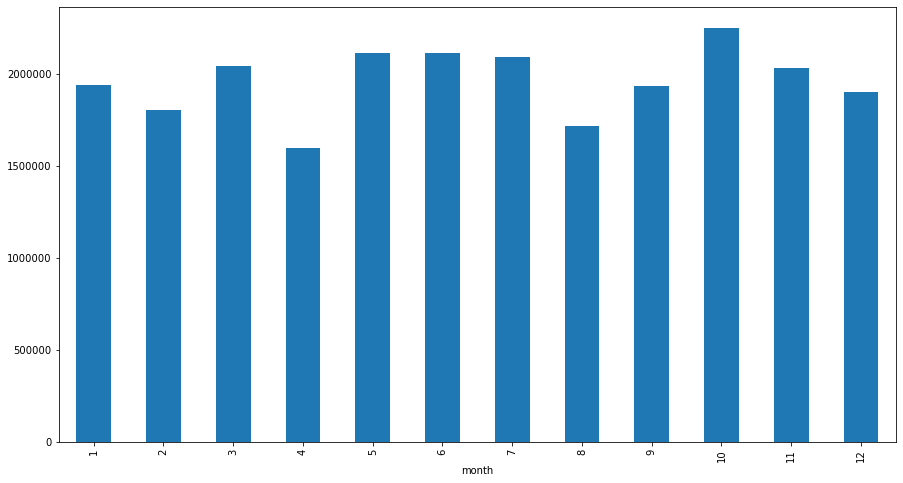

In [ ]:
# Let's plot the months on a bar graph
median_rides_by_month.plot.bar(figsize=(15,8))